In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import xarray as xr
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import fmin, hp, partial, tpe, Trials
import sys

sys.path.append('../..')
from pipeline.backtest import cross_validation
import pipeline.backtest_trading as bt
from portfolio import Portfolio
from visualization.trading_stat import analyze_stat, bear_market_suite

random_state = 42


In [4]:
base_ds = xr.open_dataset('../../data/nc_2round/base.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc_2round/fundamental_v0.nc')
market_ds = xr.open_dataset('../../data/nc_2round/market_brief.nc')

ds = xr.merge([base_ds, fundamental_v0_ds, market_ds])


In [86]:
## add feature
# ds['close_0'].diff(dim='day',n=1)/ds['close_0']
ds['return_0'] = ds['close_0']/ds['close_0'].shift(day=1) - 1
ds['close_moving_5'] = ds['close_0'].rolling(day=5).mean()
ds['close_moving_20'] = ds['close_0'].rolling(day=20).mean()
ds['close_moving_100'] = ds['close_0'].rolling(day=100).mean()
ds['close_ma_diff_5'] = ds['close_0'] - ds['close_moving_5']
ds['close_ma_diff_20'] = ds['close_0'] - ds['close_moving_20']
ds['close_ma_diff_100'] = ds['close_0'] - ds['close_moving_100']

In [64]:
class PEMAPortfolio(Portfolio):
    def __init__(self):
        pass

    def initialize(self, X, y):
        pass

    def train(self, X, y):
        pass

    def construct(self, X):
        current_day = X.day.max().item()
        X_ = X.sel(day=[current_day])
        ma_5 = X_.close_moving_5
        ma_20 = X_.close_moving_20
        is_bull = ma_5/ma_20 > 1
        is_bear = ma_20/ma_5 > 1
        pe = X_.pe
        good_company = (pe > 0) & (pe < 15) & is_bull
        market_pe = pe.median().item()
        investment = np.where(good_company, pe**(-5), 0)
        s = max(1e-6, investment.sum())
        y = investment / s
        propose = y * min(50 / market_pe, 1)
        propose[propose < 0.01] = 0
        # print(current_day, np.where(propose > 0), propose[np.where(propose > 0)])
        return propose

  0%|          | 0/141 [00:00<?, ?it/s]

Summary of scores:
1. APR: 32.0989%
2. Sharpe: 1.3173
3. Maximum drawdown: 0.1309
4. Median number of traded instruments: 0.0


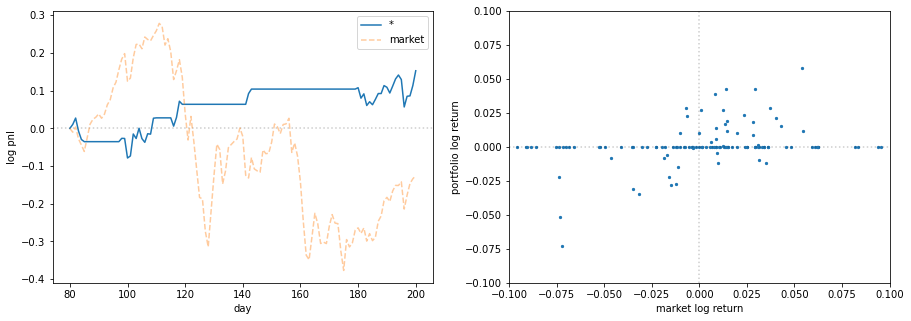

In [65]:
pe_ma_portfolio = PEMAPortfolio()
# stat = bt.cross_validation(pe_portfolio, ['pe', 'close_moving_5', 'close_moving_20'],
#                            ds, lookback_window=3, need_full_lookback=True)
stat = bt.cross_validation(pe_ma_portfolio, ['pe', 'close_moving_5', 'close_moving_20'],
                           ds.sel(day=slice(70, 210)), lookback_window=3, need_full_lookback=True)

analyze_stat(stat)

### Let's fight the bull and bear!

In [136]:
class PE_Bear_Portfolio(Portfolio):
    def __init__(self):
        pass

    def initialize(self, X, y):
        pass

    def train(self, X, y):
        pass

    def construct(self, X):
        current_day = X.day.max().item()
        X_ = X.sel(day=[current_day])
        pe = X_.pe
        bear_thr = -0.05
        bull_thr = 0.05
        market_pe = pe.median().item()

        dont_buy = (X_.return_0 < bear_thr) & (X_.close_ma_diff_100 < 0)

        good_company = (pe > 0) & (pe < 15) & (1-dont_buy)
        investment = np.where(good_company, pe**(-5), 0)

        # add stocks with bull performance when market is good
        investment += (market_pe<40)*(X_.close_ma_diff_100>0)*(X_.close_ma_diff_5>0)*(X_.close_ma_diff_20>0)\
                      *(X_.return_0>bull_thr)*(X_.return_0-bull_thr)/(X_.return_0-bull_thr).max()*investment.max()
        s = max(1e-6, investment.sum())
        y = investment / s

        propose = (y* min(50 / market_pe, 1)).squeeze()

        propose[propose < 0.01] = 0
        # print(current_day, np.where(propose > 0), propose[np.where(propose > 0)])
        return propose

  0%|          | 0/1700 [00:00<?, ?it/s]

Summary of scores:
1. APR: 71.9495%
2. Sharpe: 1.6026
3. Maximum drawdown: 0.1766
4. Median number of traded instruments: 6.0
Summary of scores:
1. APR: 1.1808%
2. Sharpe: 0.0399
3. Maximum drawdown: 0.1322
4. Median number of traded instruments: 6.0
Summary of scores:
1. APR: 29.8774%
2. Sharpe: 0.9435
3. Maximum drawdown: 0.1643
4. Median number of traded instruments: 6.0


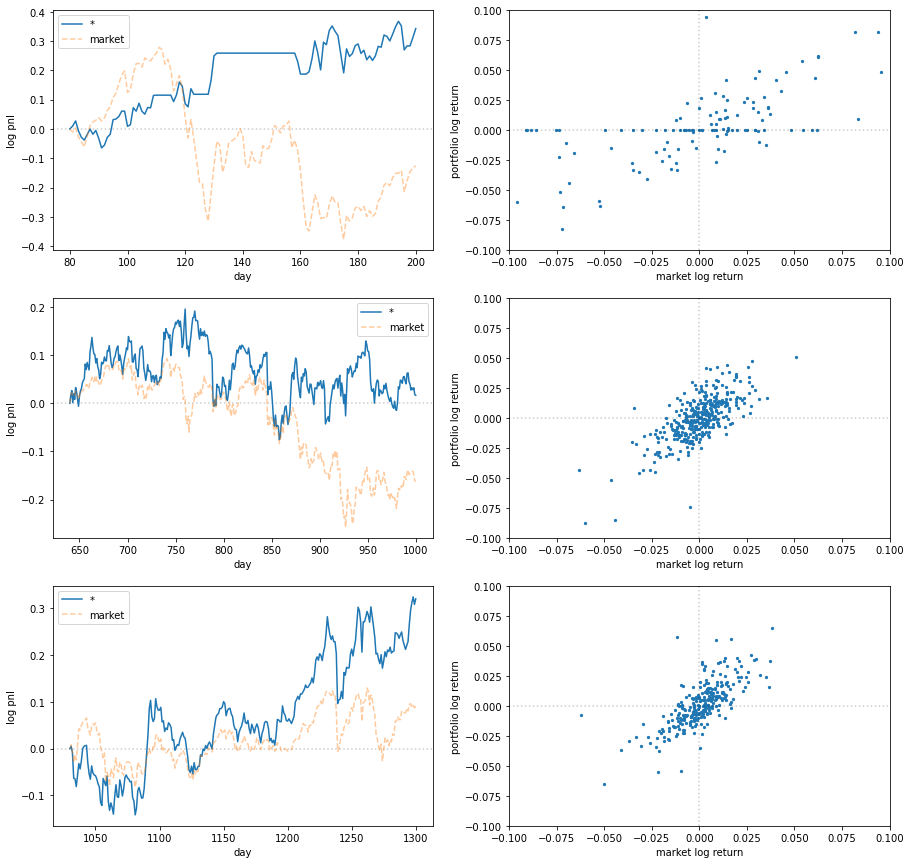

In [137]:
## pe50; pe^-5; bear_thr -0.05; ma100; with bull stocks

pe_bear_portfolio = PE_Bear_Portfolio()
stat = bt.cross_validation(pe_bear_portfolio, ['pe',  'close_ma_diff_5', 'close_ma_diff_20', 'close_ma_diff_100', 'return_0'],
                           ds, lookback_window=3, need_full_lookback=True)
# stat = bt.cross_validation(pe_bear_portfolio, ['pe', 'close_ma_diff_5', 'close_ma_diff_20', 'close_ma_diff_100', 'return_0'],
#                            ds.sel(day=slice(70, 210)), lookback_window=3, need_full_lookback=True)

analyze_stat(stat)

  0%|          | 0/1700 [00:00<?, ?it/s]

Summary of scores:
1. APR: 73.9585%
2. Sharpe: 1.6725
3. Maximum drawdown: 0.1684
4. Median number of traded instruments: 4.0
Summary of scores:
1. APR: 3.6481%
2. Sharpe: 0.1201
3. Maximum drawdown: 0.1325
4. Median number of traded instruments: 4.0
Summary of scores:
1. APR: 13.7950%
2. Sharpe: 0.4646
3. Maximum drawdown: 0.1785
4. Median number of traded instruments: 4.0


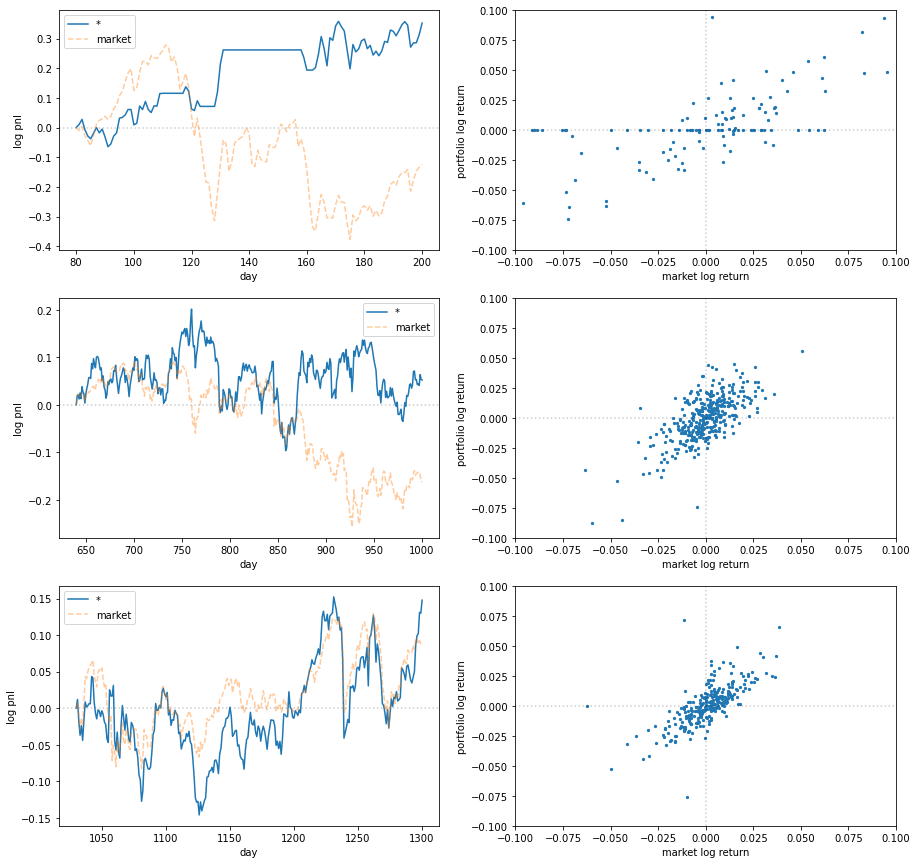

In [85]:
## pe50; pe^-5; bear_thr -0.05; ma20

pe_bear_portfolio = PE_Bear_Portfolio()
stat = bt.cross_validation(pe_bear_portfolio, ['pe', 'close_ma_diff_20', 'close_ma_diff_100', 'return_0'],
                           ds, lookback_window=3, need_full_lookback=True)
# stat = bt.cross_validation(pe_bear_portfolio, ['pe', 'close_ma_diff_20', 'close_ma_diff_100', 'return_0'],
#                            ds.sel(day=slice(70, 210)), lookback_window=3, need_full_lookback=True)

analyze_stat(stat)

  0%|          | 0/1700 [00:00<?, ?it/s]

Summary of scores:
1. APR: 63.6059%
2. Sharpe: 1.4704
3. Maximum drawdown: 0.1677
4. Median number of traded instruments: 4.0
Summary of scores:
1. APR: 2.2604%
2. Sharpe: 0.0746
3. Maximum drawdown: 0.1325
4. Median number of traded instruments: 4.0
Summary of scores:
1. APR: 13.7879%
2. Sharpe: 0.4643
3. Maximum drawdown: 0.1785
4. Median number of traded instruments: 4.0


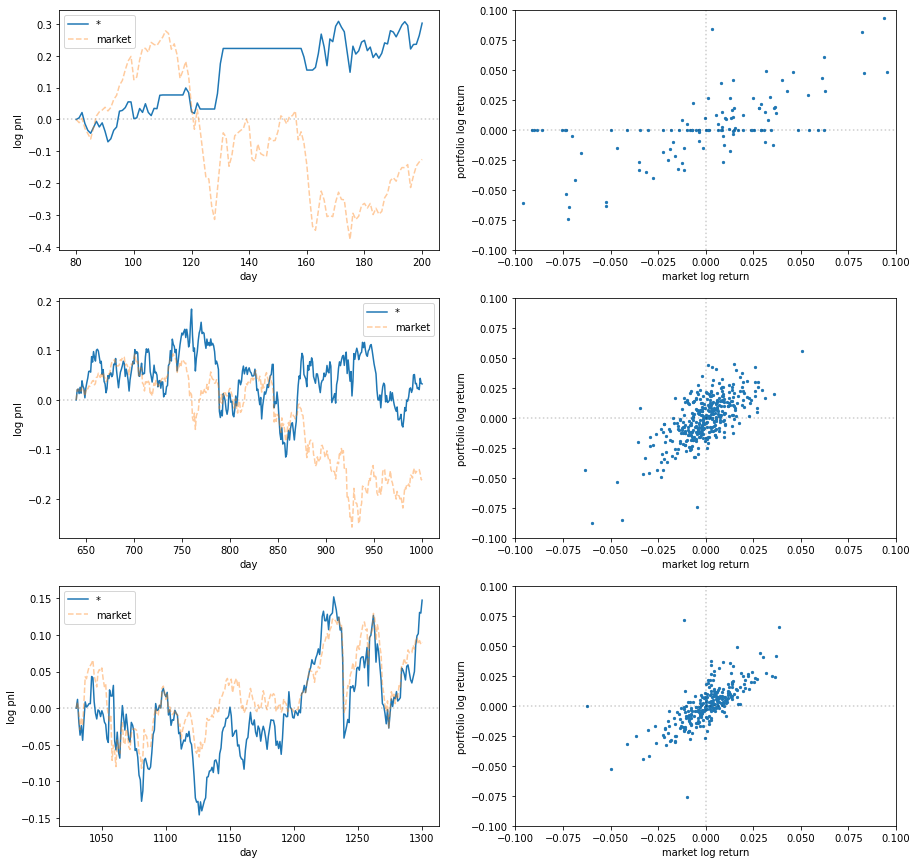

In [88]:
## pe50; pe^-5; bear_thr -0.05; ma5

pe_bear_portfolio = PE_Bear_Portfolio()
stat = bt.cross_validation(pe_bear_portfolio, ['pe', 'close_ma_diff_20', 'close_ma_diff_5', 'return_0'],
                           ds, lookback_window=3, need_full_lookback=True)
# stat = bt.cross_validation(pe_bear_portfolio, ['pe', 'close_ma_diff_20', 'close_ma_diff_100', 'return_0'],
#                            ds.sel(day=slice(70, 210)), lookback_window=3, need_full_lookback=True)

analyze_stat(stat)

  0%|          | 0/1700 [00:00<?, ?it/s]

Summary of scores:
1. APR: 83.8701%
2. Sharpe: 1.8490
3. Maximum drawdown: 0.1684
4. Median number of traded instruments: 4.0
Summary of scores:
1. APR: 6.7235%
2. Sharpe: 0.2222
3. Maximum drawdown: 0.1325
4. Median number of traded instruments: 4.0
Summary of scores:
1. APR: 14.7512%
2. Sharpe: 0.5010
3. Maximum drawdown: 0.1785
4. Median number of traded instruments: 4.0


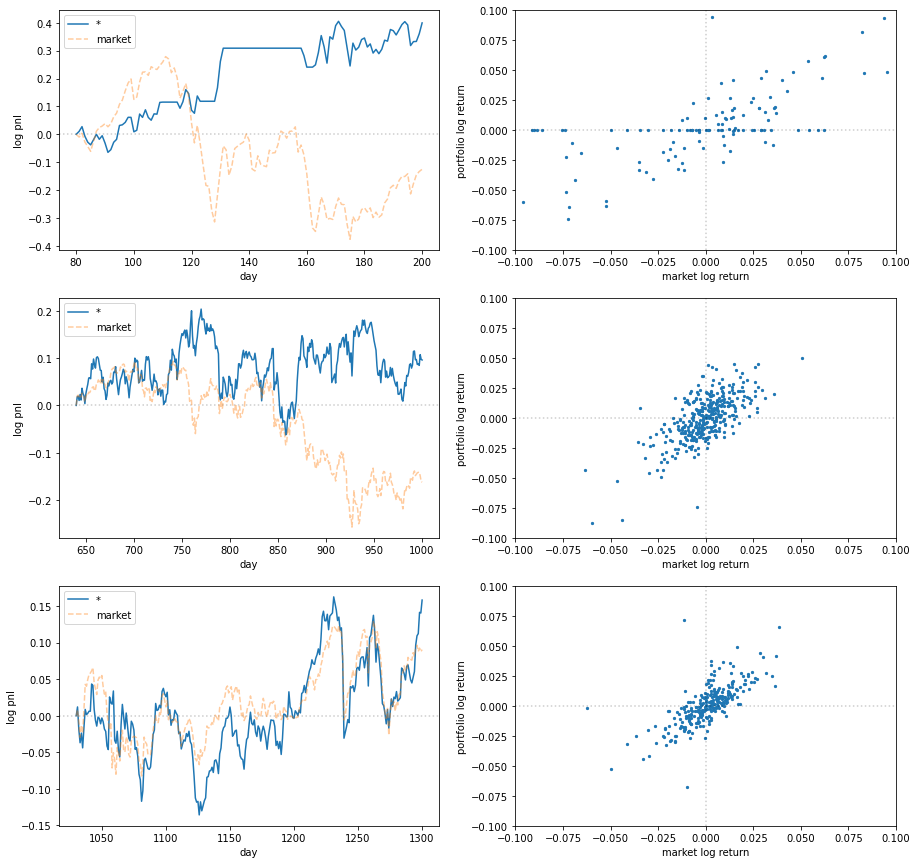

In [90]:
## pe50; pe^-5; bear_thr -0.05; ma100

pe_bear_portfolio = PE_Bear_Portfolio()
stat = bt.cross_validation(pe_bear_portfolio, ['pe', 'close_ma_diff_20', 'close_ma_diff_100', 'return_0'],
                           ds, lookback_window=3, need_full_lookback=True)
# stat = bt.cross_validation(pe_bear_portfolio, ['pe', 'close_ma_diff_20', 'close_ma_diff_100', 'return_0'],
#                            ds.sel(day=slice(70, 210)), lookback_window=3, need_full_lookback=True)

analyze_stat(stat)

1. Now we seem to be able to beat slow drop; how to identify big drop?
2. Should one normalize PE threshold to some degree (e.g. by market index) to keep track with the market?

In [110]:
ds.sel(day=slice(800,1000)).pe.median().item()**(-5)

1.0815928836763332e-07